In [162]:
# import necessary functions
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import typing
import random

random.seed(0)

In [163]:
# define function that prints summary statistics of features
def get_summaries(data: pd.DataFrame, features: typing.List[str], year: int) \
    -> None:

    data_year = data[data['Year'] == year]

    for feature in features:
        print(f"{feature}: ")
        print(f"{data_year[feature].describe()}\n")

In [164]:
# define function that creates line plots of co2 emissions over time
def plot_lines(data: pd.DataFrame, feature: str, plot_every: int) -> None:

    # Adjust the size of the figure
    plt.figure(figsize=(20, 10))  # Adjust width, height as needed
    
    # Plot line graphs for the specified feature for each country
    for i, country in enumerate(set(data['Entity'])):
        if i % plot_every == 0:
            country_data = data[data['Entity'] == country]
            # Drop rows where the year or the feature value is NaN
            feature_data = country_data[['Year', feature]].dropna()
            plt.plot(feature_data['Year'], feature_data[feature], marker='o', label=country)
    
    plt.title('Sample of CO2 Emissions from 2000 to 2020')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions (metric tons per person)')
    plt.xticks(range(2000, 2020, 2))
    plt.legend()  # Add a legend

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
    plt.show()

In [165]:
# define function that creates historams of all variables
def plot_histograms(data: pd.DataFrame, features: typing.List[str], year: int) \
    -> None:

    data_year = data[data['Year'] == year]

    plt.figure(figsize=(15, 10))  # Adjust the size of the figure as needed

    for i, feature in enumerate(features):
        plt.subplot(len(features) + 1, 1, i + 1)  # Create a subplot for each feature
        data_year[feature].hist(bins=20)  # Adjust the number of bins as needed
        plt.title(f"{feature} [{year}]")
        plt.ylabel('Frequency')

    plt.tight_layout()  # Adjust the layout so that plots do not overlap
    plt.show()

In [166]:
# define function that uses k folds to find best depth value for tree
def get_best_depth(k: int, max_depth: int, X: pd.DataFrame, y: pd.Series) \
    -> typing.List[float]:

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    depth_scores = []

    for depth in range(1, max_depth):
        regressor = DecisionTreeRegressor(max_depth=depth, random_state=0)
        curr_score = cross_val_score(regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
        depth_scores.append(curr_score.mean())

    return depth_scores

In [167]:
# define function to find the best ccp_alpha using cross-validation
def get_best_ccp_alpha(k: int, ccp_alphas: np.ndarray, X: pd.DataFrame, y: pd.Series) \
    -> float:

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    sampled_ccp_alphas = ccp_alphas[::50]
    alpha_scores = []

    for ccp_alpha in sampled_ccp_alphas:
        regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
        curr_score = cross_val_score(regressor, X, y, cv=kf, scoring='neg_mean_absolute_error')
        alpha_scores.append(curr_score.mean())

    # return the alpha that maximizes the cross-validated score
    return ccp_alphas[np.argmax(alpha_scores)]

In [199]:
# define function to get which lead each country falls into
def get_countries_per_leaf(data, features, model):
    # Get the leaf indices for each sample in the data
    leaf_indices = model.apply(data[features])

    # Map each sample to its corresponding leaf index
    data['leaf_index'] = leaf_indices
    
    # Initialize a dictionary to hold sets of years for each country in each leaf
    countries_per_leaf = {}
    
    for _, row in data.iterrows():
        leaf_index = row['leaf_index']
        country = row['Entity']
        year = row['Year']
        
        # If the leaf index is not in the dictionary, add it with an empty dictionary
        if leaf_index not in countries_per_leaf:
            countries_per_leaf[leaf_index] = {}
        
        # If the country is not in the dictionary for the leaf, add it with an empty set
        if country not in countries_per_leaf[leaf_index]:
            countries_per_leaf[leaf_index][country] = set()
        
        # Add the year to the set of years for this country in this leaf
        countries_per_leaf[leaf_index][country].add(year)
    
    # Convert sets of years to sorted lists and concatenate with country names
    for leaf in countries_per_leaf:
        for country in countries_per_leaf[leaf]:
            years = sorted(list(countries_per_leaf[leaf][country]))
            countries_per_leaf[leaf][country] = f"{country} ({', '.join(map(str, years))})"
    
    # Now, create the final dictionary with leaf indices and country-year strings
    countries_per_year = {leaf: list(countries.values()) for leaf, countries in countries_per_leaf.items()}
    countries = data.groupby('leaf_index')['Entity'].apply(list).to_dict()

    return countries_per_year, countries

In [169]:
# load data
data = pd.read_csv('global-data-on-sustainable-energy.csv')

In [170]:
# Define features and the variable to be predicted
features = [
    'Access to electricity (% of population)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from nuclear (TWh)',
    'Electricity from renewables (TWh)'
]
to_be_predicted = 'Value_co2_emissions_kt_by_country'

# Selecting the relevant data with 'Year' for grouping
X = data[features + ['Year']]
y = data[to_be_predicted]

# Group by 'Year' and fill missing values with the median of each group
# Using `.loc` to ensure we are modifying the original DataFrame
for feature in features:
    X.loc[:, feature] = X.groupby('Year')[feature].transform(lambda x: x.fillna(x.median()))

# Assuming that 'y' does not depend on 'Year' for median calculation
y = y.fillna(y.median())

# Dropping the 'Year' column from X after filling missing values
X = X.drop(columns=['Year'])


In [171]:
# generate summary stats
get_summaries(data, features + [to_be_predicted], 2000)

Access to electricity (% of population): 
count    170.000000
mean      73.121292
std       34.505240
min        1.613591
25%       42.155707
50%       94.715340
75%      100.000000
max      100.000000
Name: Access to electricity (% of population), dtype: float64

Electricity from fossil fuels (TWh): 
count     172.000000
mean       49.466453
std       231.400336
min         0.000000
25%         0.157500
50%         2.090000
75%        21.867500
max      2697.280000
Name: Electricity from fossil fuels (TWh), dtype: float64

Electricity from nuclear (TWh): 
count    167.000000
mean      13.430838
std       72.124282
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      753.890000
Name: Electricity from nuclear (TWh), dtype: float64

Electricity from renewables (TWh): 
count    172.000000
mean      14.882326
std       50.358950
min        0.000000
25%        0.010000
50%        0.760000
75%        6.475000
max      363.700000
Name: Electricity from rene

In [172]:
get_summaries(data, features + [to_be_predicted], 2020)

Access to electricity (% of population): 
count    175.000000
mean      85.460078
std       24.568644
min        7.241338
25%       74.568810
50%      100.000000
75%      100.000000
max      100.000000
Name: Access to electricity (% of population), dtype: float64

Electricity from fossil fuels (TWh): 
count     174.000000
mean       82.582701
std       444.797952
min         0.000000
25%         0.415000
50%         3.415000
75%        29.962500
max      5184.130000
Name: Electricity from fossil fuels (TWh), dtype: float64

Electricity from nuclear (TWh): 
count    169.000000
mean      13.186982
std       72.754233
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      789.880000
Name: Electricity from nuclear (TWh), dtype: float64

Electricity from renewables (TWh): 
count     174.000000
mean       40.063448
std       185.960544
min         0.000000
25%         0.210000
50%         2.935000
75%        14.655000
max      2184.940000
Name: Electricity f

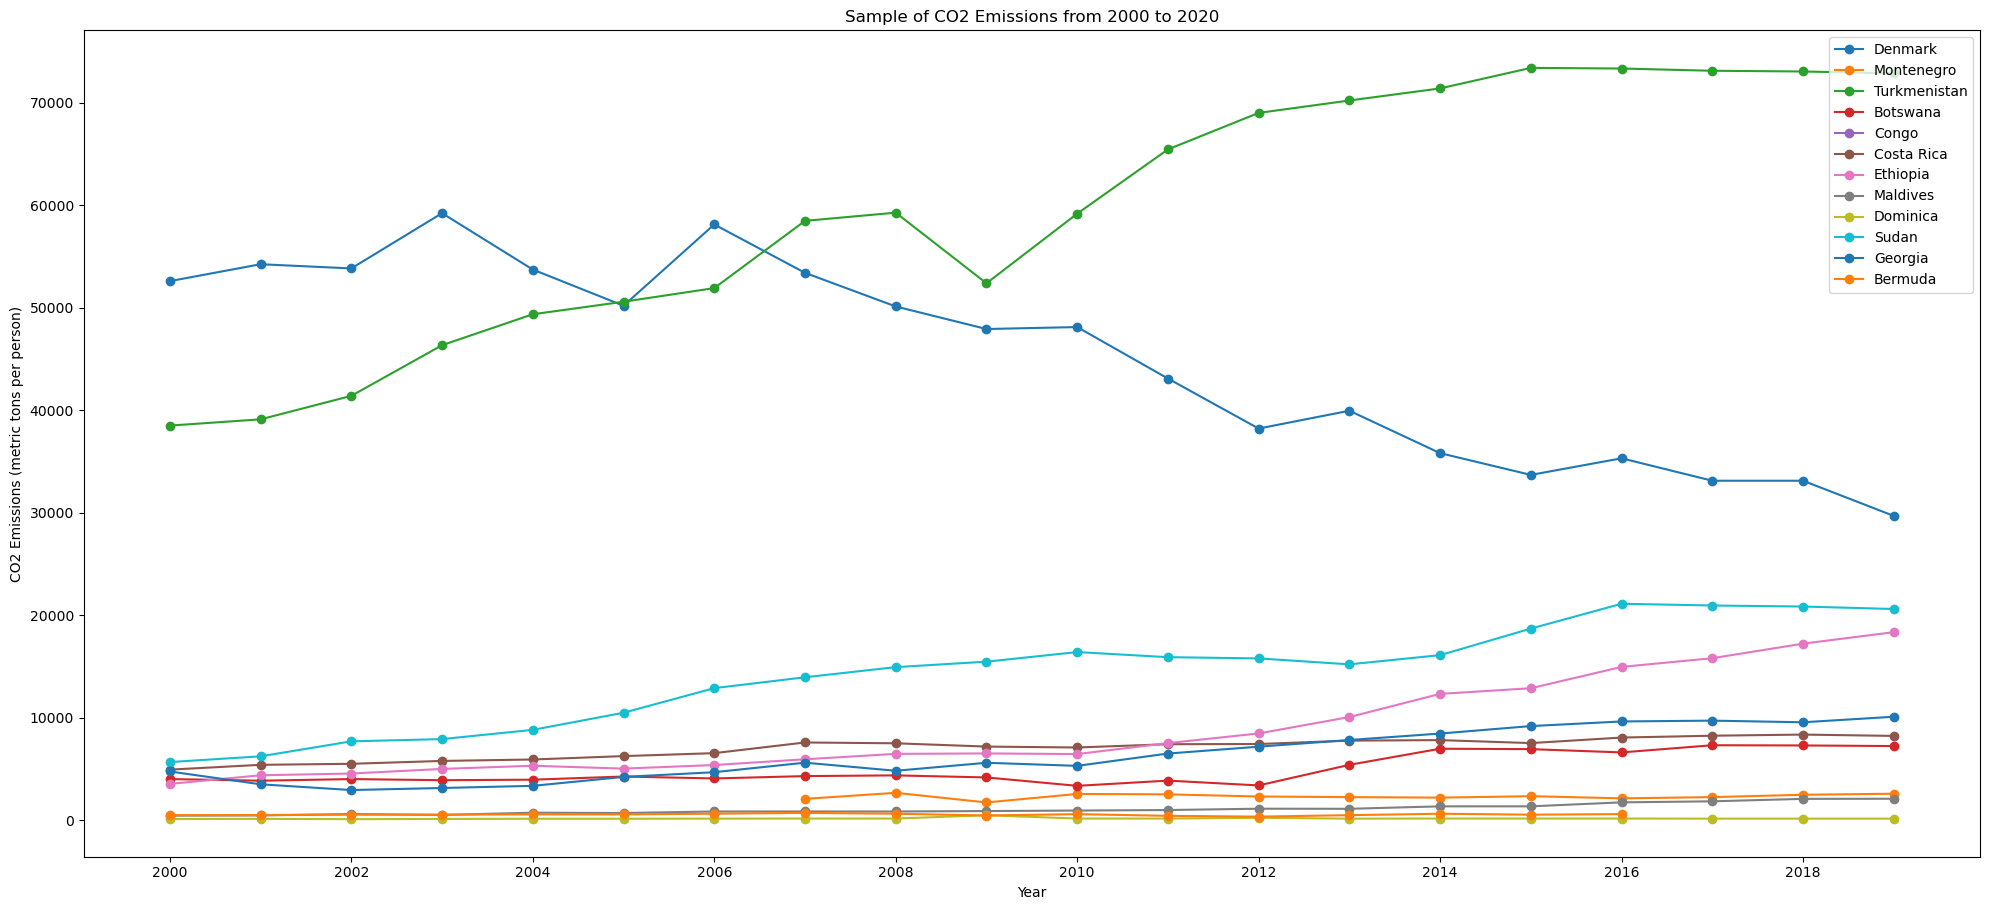

In [173]:
# generate line plots of co2 emissions over time
plot_lines(data, to_be_predicted, 15)

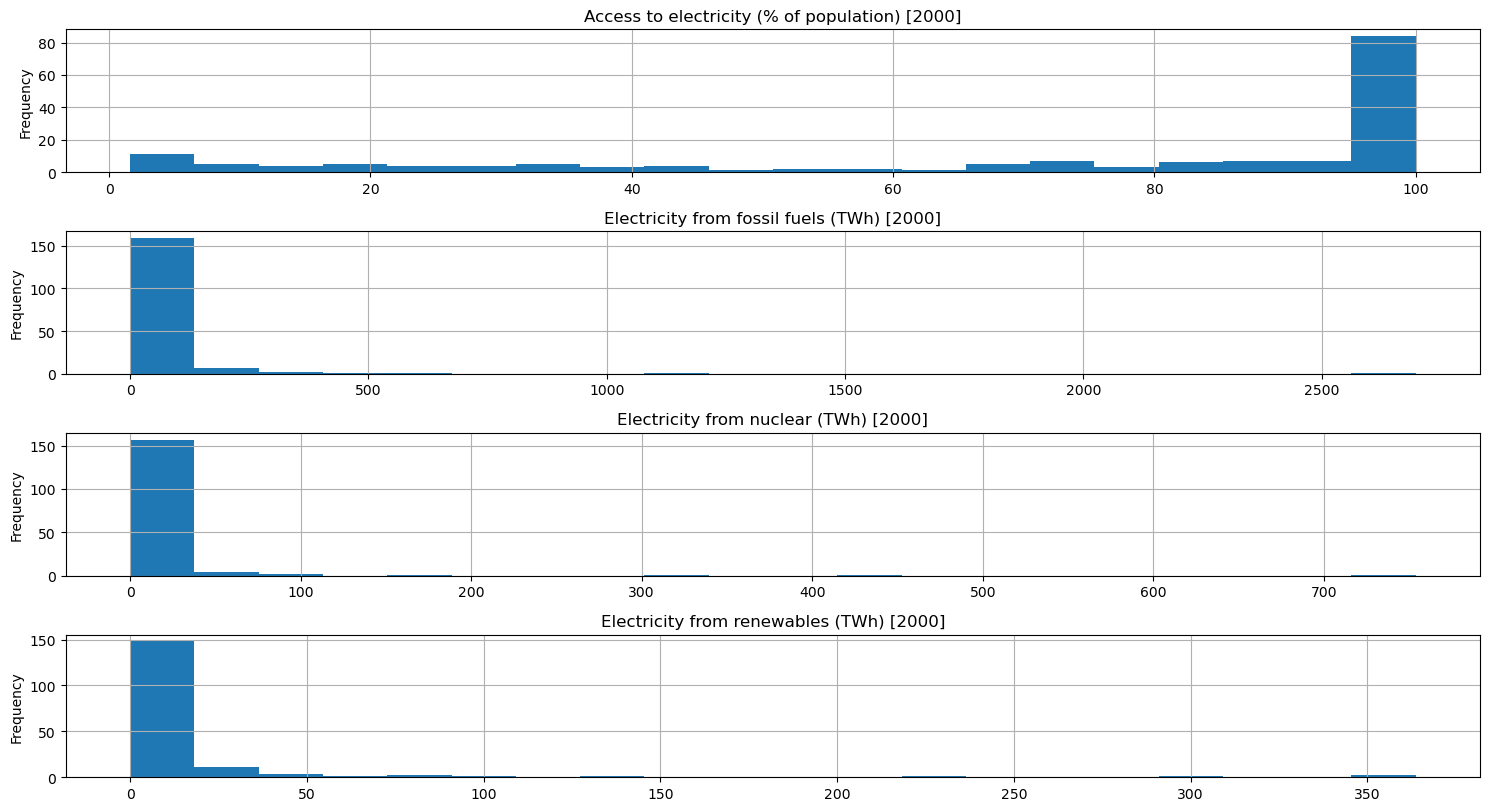

In [174]:
plot_histograms(data, features, 2000)

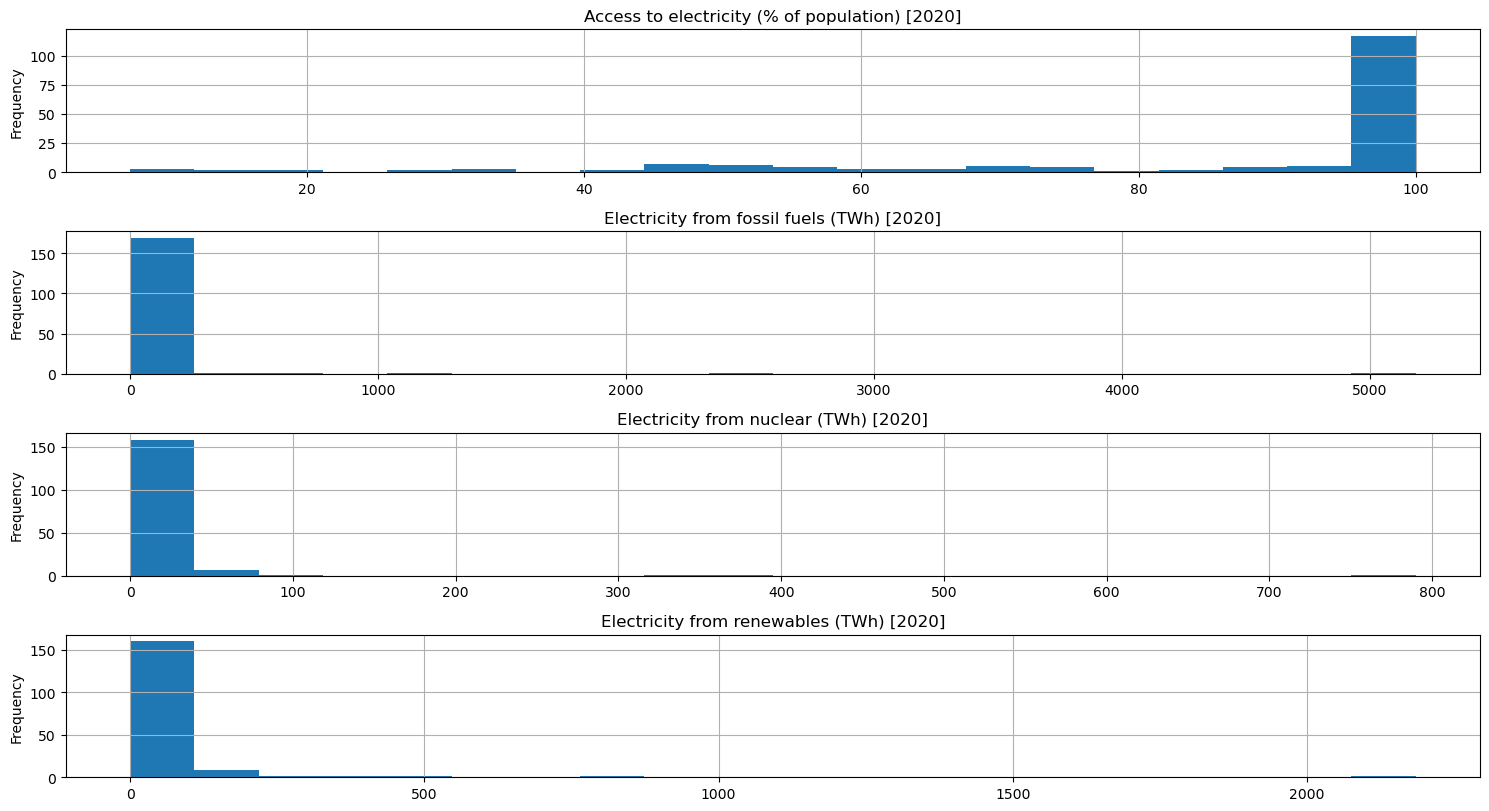

In [175]:
plot_histograms(data, features, 2020)

In [176]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [177]:
# find best ccp_alpha for pruning
regressor = DecisionTreeRegressor(random_state=0)
path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas 

# decide optimal ccp_alpha
k = 10
optimal_ccp_alpha = get_best_ccp_alpha(k, ccp_alphas, X_train, y_train)
print(f"Optimal ccp_alpha for pruning: {optimal_ccp_alpha}")


Optimal ccp_alpha for pruning: 4.610324531260414e-13


In [178]:
# determine optimal depth using the get_best_depth function
max_depth = 10
cv_scores = get_best_depth(k, max_depth, X_train, y_train)

# find depth with the highest cross-validated score
best_depth = cv_scores.index(max(cv_scores)) + 1  # +1 because index 0 corresponds to depth 1
print(f"Best tree depth: {best_depth}")

Best tree depth: 2


In [179]:
# initialize decision tree regressor model with pruning and fit training data
regressor = DecisionTreeRegressor(max_depth=best_depth, random_state=0, ccp_alpha=optimal_ccp_alpha)
regressor.fit(X_train, y_train)

# test model with test data and calculate MSE
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 90309900113.46992
Mean Absolute Error: 96468.60065967555


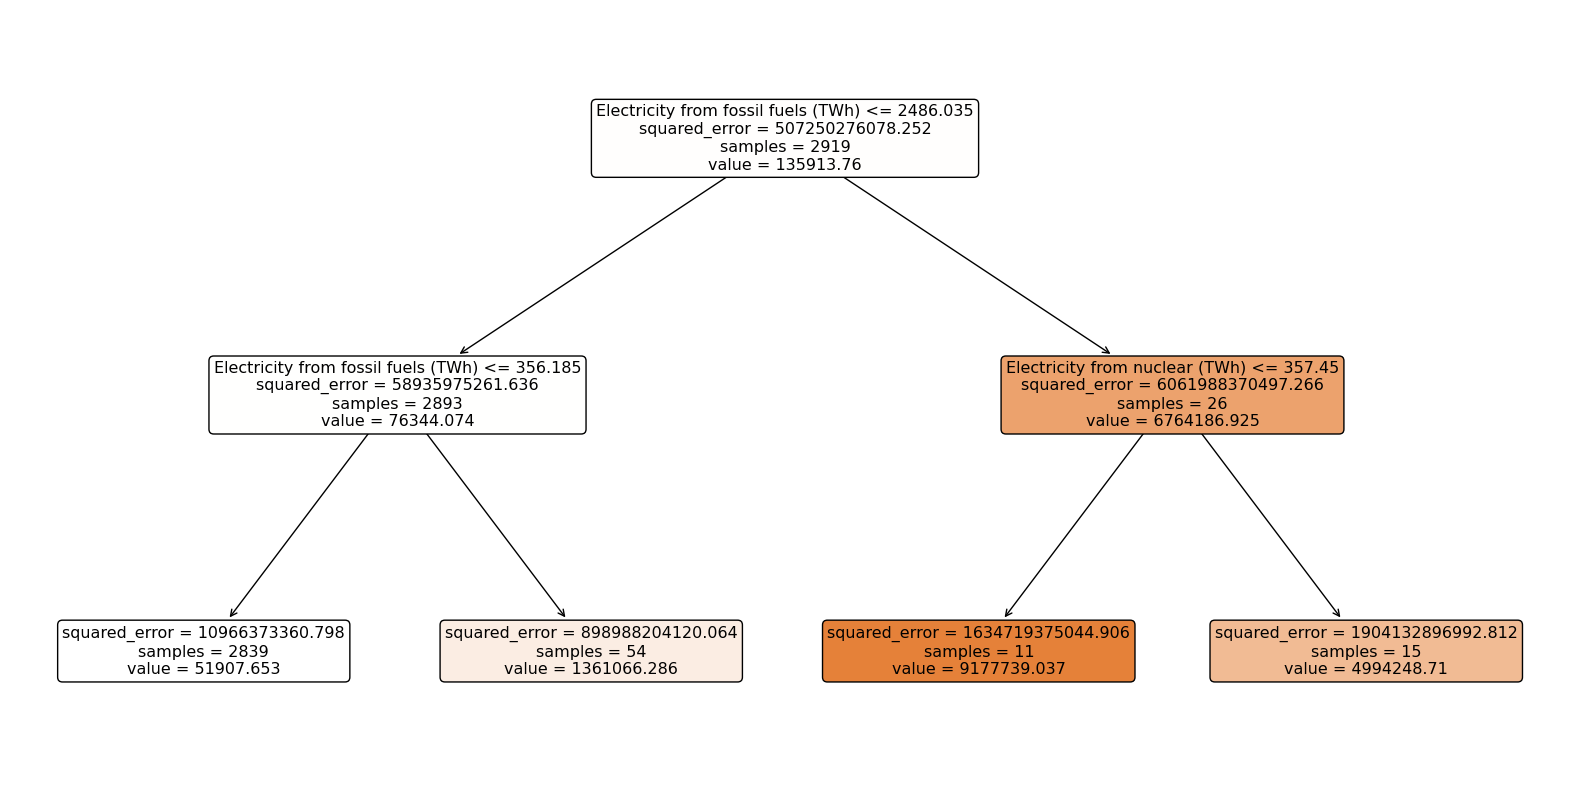

In [180]:
plt.figure(figsize=(20,10))
tree.plot_tree(regressor, 
               feature_names=features, 
               filled=True, 
               rounded=True)
plt.show()

In [201]:
# determine which countries fall into which categories
countries_w_year, countries_wo_year = get_countries_per_leaf(data, features, regressor)

# see which countries ended up in which leaf by year
counter = 1
for leaf_index, countries in countries_w_year.items():
    if len(countries) == 0:
        continue
    print(f"Leaf {counter}: {', '.join(str(c) for c in countries)}")
    counter += 1
    

Leaf 1: Afghanistan (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Albania (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Algeria (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Angola (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Antigua and Barbuda (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Argentina (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Armenia (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), Aruba (2000, 2001, 2002

In [202]:
# see which countries ended up in which leaf by year
counter = 1
for leaf_index, countries in countries_wo_year.items():
    if len(countries) == 0:
        continue
    print(f"Leaf {counter} - {len(countries)}: {', '.join(str(c) for c in set(countries))}")
    counter += 1

Leaf 1 - 3548: Denmark, Jordan, Kenya, Bulgaria, Cuba, Lithuania, Burundi, North Macedonia, Myanmar, Czechia, Libya, Mauritius, Qatar, South Sudan, Suriname, Montenegro, Angola, Finland, Saint Lucia, Azerbaijan, Morocco, Cyprus, Switzerland, Grenada, Trinidad and Tobago, Papua New Guinea, Benin, Greece, Haiti, Madagascar, Turkmenistan, Ecuador, Brazil, Cayman Islands, Sri Lanka, Singapore, Ukraine, Norway, Barbados, Belgium, Afghanistan, Germany, South Africa, Saint Vincent and the Grenadines, Botswana, Namibia, Gabon, Uganda, Yemen, Bahrain, Albania, Eritrea, Kyrgyzstan, Equatorial Guinea, Colombia, Hungary, Tunisia, France, Nigeria, Congo, New Zealand, Belarus, Paraguay, United Arab Emirates, Jamaica, Guinea-Bissau, Malawi, Bhutan, Poland, Latvia, El Salvador, Guyana, French Guiana, Costa Rica, Guatemala, Australia, Serbia, Somalia, Gambia, Turkey, Cameroon, Canada, Central African Republic, Eswatini, Indonesia, Liberia, Dominican Republic, Burkina Faso, Ethiopia, Panama, Slovakia, E